# Pylops - Marchenko redatuming with multiple virtual points

### Author: M.Ravasi

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import cg, lsqr
from scipy.signal import convolve, filtfilt

from pylops                            import LinearOperator
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import *
from pylops.optimization.leastsquares  import *

## Inputs

Input parameters 

In [2]:
inputfile = '../data/marchenko/input.npz' # choose file in testdata folder of repo

vel = 2400.0        # velocity
toff = 0.045        # direct arrival time shift
nsmooth = 10        # time window smoothing 
nfmax = 500         # max frequency for MDC (#samples)
nstaper = 11        # source/receiver taper lenght
n_iter = 10         # iterations

jr = 1              # subsampling in r
js = 1              # subsampling in s

Load input

In [3]:
inputdata = np.load(inputfile)

Read and visualize geometry

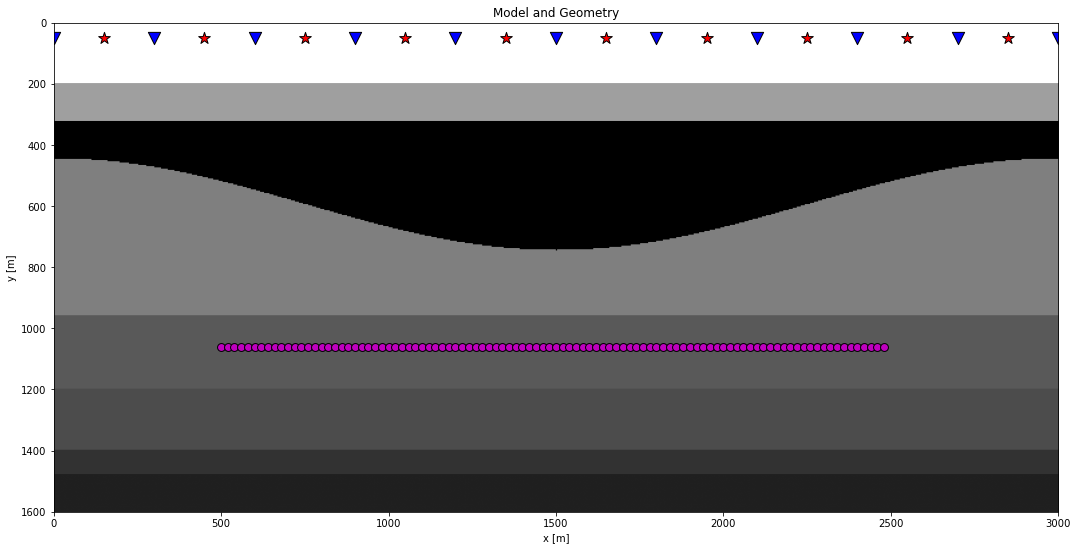

In [4]:
# Receivers
r = inputdata['r'][:,::jr]
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s'][:,::js]
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# Virtual points
nvs = 100
vs = np.array([np.arange(nvs)*20 + 500, 
               np.ones(nvs)*1060])
dvs = vs[0, 1] - vs[0, 0]

# Density model
rho = inputdata['rho']
z, x = inputdata['z'], inputdata['x']

plt.figure(figsize=(18,9))
plt.imshow(rho, cmap='gray_r', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 5::10], s[1, 5::10], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, ::10],  r[1, ::10], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], marker='.', s=250, c='m', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1]);

Read data

In [5]:
# time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)
t2 = np.hstack((-np.flip(t), t[1:]))


# data
R = inputdata['R'][::js, ::jr]
R = np.swapaxes(R, 0, 1) # R[r, s, f] (for data with dipole source, you need to integrate over sources)

# tapering
taper = taper3d(nt, [ns, nr], [nstaper, nstaper], tapertype='hanning')
R = R*taper

Read wavelet to apply to subsurface fields

In [6]:
wav = inputdata['wav']
wav_c = np.argmax(wav)

Compute direct arrival for all pairs of receivers and virtual sources

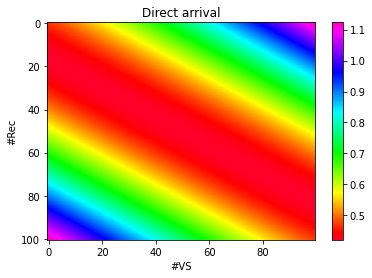

In [7]:
# direct arrival window - traveltime
directVS = np.sqrt((vs[0]-r[0][:, np.newaxis])**2+(vs[1]-r[1][:, np.newaxis])**2)/vel
directVS_off = directVS - toff

plt.figure()
im = plt.imshow(directVS, cmap='gist_rainbow')
plt.axis('tight')
plt.xlabel('#VS'),plt.ylabel('#Rec'),plt.title('Direct arrival')
plt.colorbar(im);

Create the window and analytical direct arrival

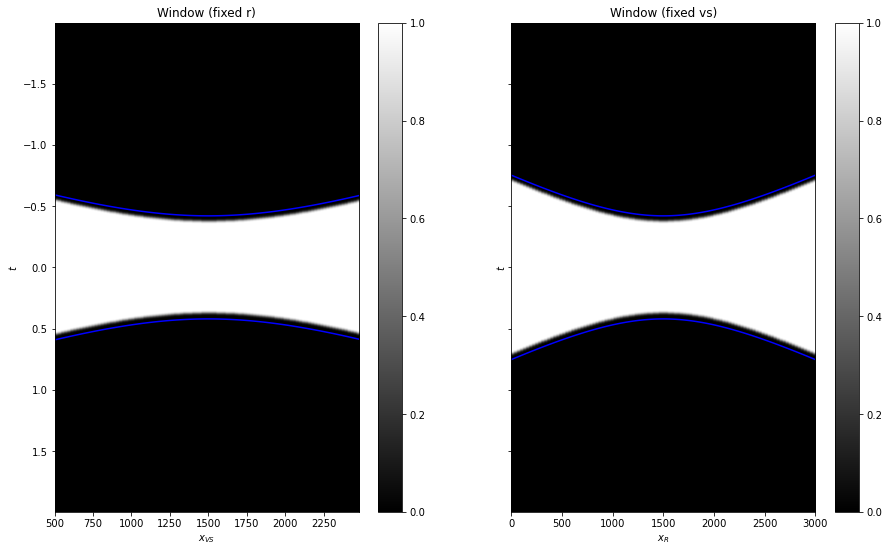

In [8]:
idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w = np.concatenate((np.flip(w, axis=-1), w[:,:, 1:]), axis=-1)

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w  = filtfilt(smooth, 1, w)    

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(w[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], -t[-1]))
axs[0].plot(vs[0], directVS[nr//2],'b'),axs[0].plot(vs[0], -directVS[nr//2],'b')
axs[0].set_title('Window (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w[:, nvs//2].T, cmap='gray', 
                   extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].plot(r[0], directVS[:, nvs//2],'b'),axs[1].plot(r[0], -directVS[:, nvs//2],'b')
axs[1].set_title('Window (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

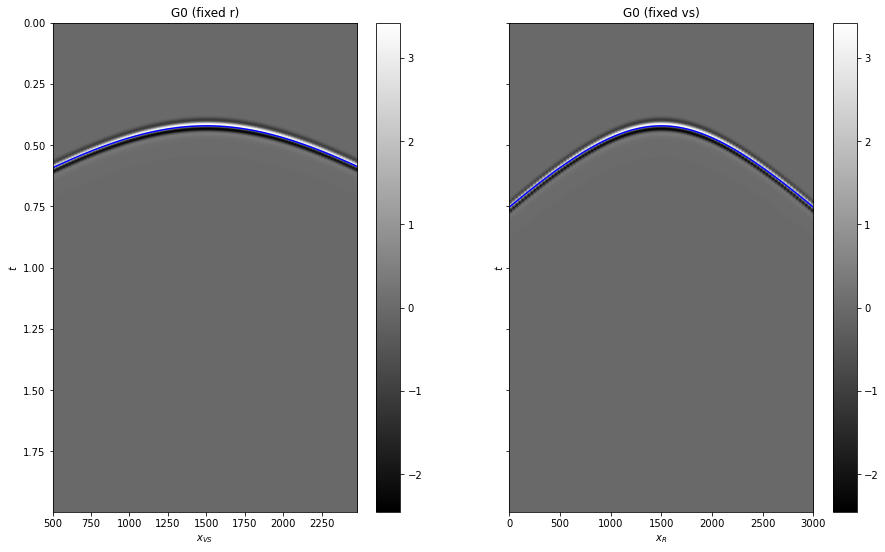

In [9]:
G0sub_ana = np.zeros((nr, nvs, nt))
for ivs in range(nvs):
    G0sub_ana[:, ivs] = directwave(wav, directVS[:,ivs], nt, dt, nfft=int(2**(np.ceil(np.log2(nt))))).T

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_ana[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].plot(vs[0], directVS[nr//2],'b')
axs[0].set_title('G0 (fixed r)'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(G0sub_ana[:,nvs//2].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].plot(r[0], directVS[:, nvs//2],'b')
axs[1].set_title('G0 (fixed vs)'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

## Marchenko redatuming with indipendent sources

Let's now create and apply the Marchenko operator for multiple virtual points

In [10]:
MarchenkoWM = Marchenko(R, dt=dt, dr=dr, nfmax=nfmax, wav=wav,
                        toff=toff, nsmooth=nsmooth)

In [11]:
t0 = time.time()
f1_inv_minus, f1_inv_plus, p0_minus, g_inv_minus, g_inv_plus = \
    MarchenkoWM.apply_multiplepoints(directVS, nfft=2**11, rtm=True, greens=True,
                                     dottest=False, **dict(iter_lim=n_iter, show=True))
g_inv_tot = g_inv_minus + g_inv_plus
print('Indipendent source Marchenko took %f s' % (time.time()-t0))

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 32299800 rows and 32299800 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.855e+02  3.855e+02    1.0e+00  2.7e-03
     1  0.00000e+00   1.663e+02  1.663e+02    4.3e-01  9.4e-01   1.1e+00  1.0e+00
     2  0.00000e+00   9.367e+01  9.367e+01    2.4e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   6.966e+01  6.966e+01    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   4.709e+01  4.709e+01    1.2e-01  3.3e-01   2.5e+00  5.1e+00
     5  0.00000e+00   3.616e+01  3.616e+01    9.4e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.903e+01  2.903e+01    7.5e-02  2.2e-01   3.3e+00  8.5e+00
     7  0.00000e+00   2.065e+01  2.065e+01    5.4e-02  2.3e-01   3.6e+00  1.1e+01
     8  0.00000e+00   1.56

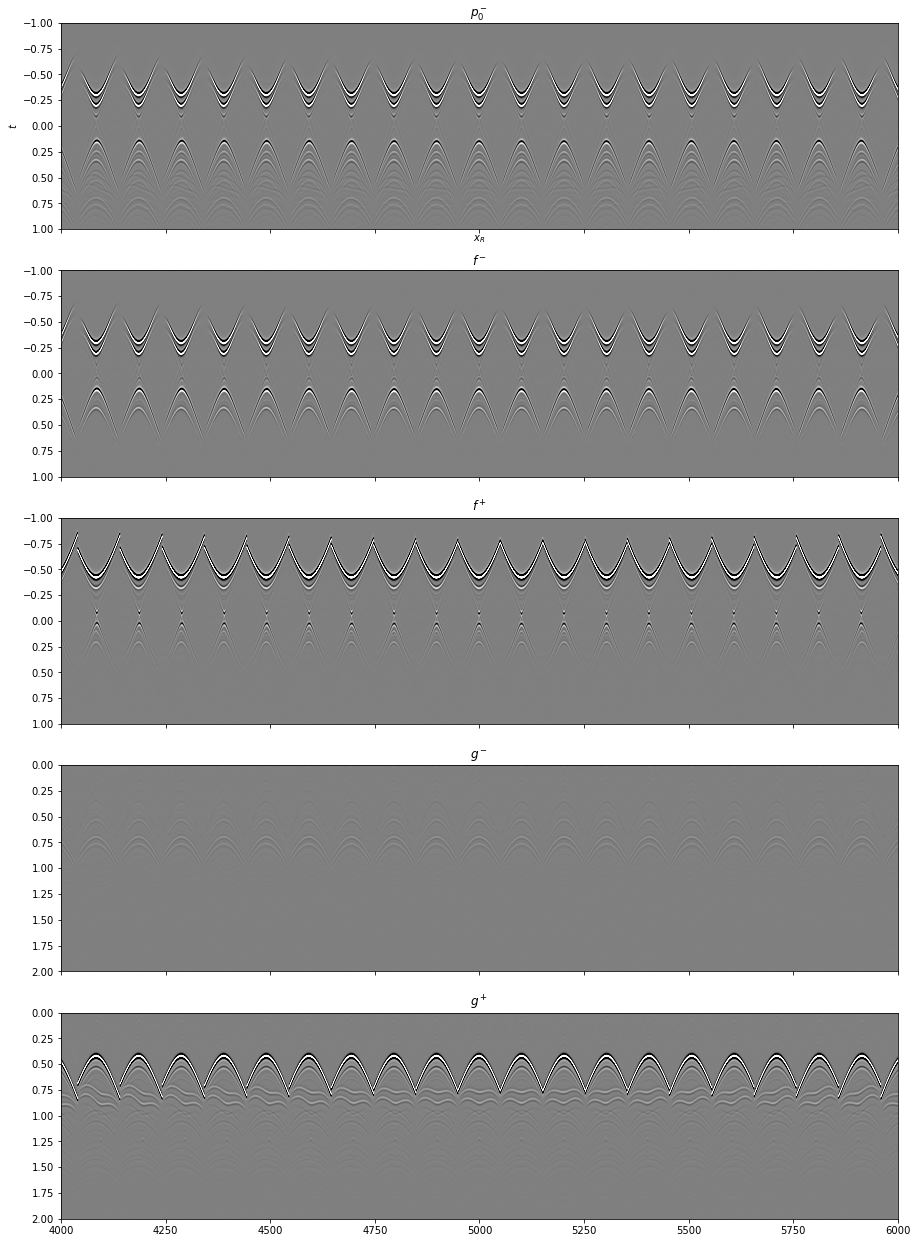

In [12]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15, 22))
axs[0].imshow(np.swapaxes(p0_minus, 0, 1).reshape(nr*nvs, 2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);

axs[1].imshow(np.swapaxes(f1_inv_minus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(np.swapaxes(f1_inv_plus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(np.swapaxes(g_inv_minus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);
axs[4].imshow(np.swapaxes(g_inv_plus, 0, 1).reshape(nr*nvs,2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);
axs[4].set_xlim(4000, 6000);

## Marchenko redatuming with encoded sources

We now repeat the estimation with sim. virtual sources

In [13]:
nsim = 2 # number of sim sources

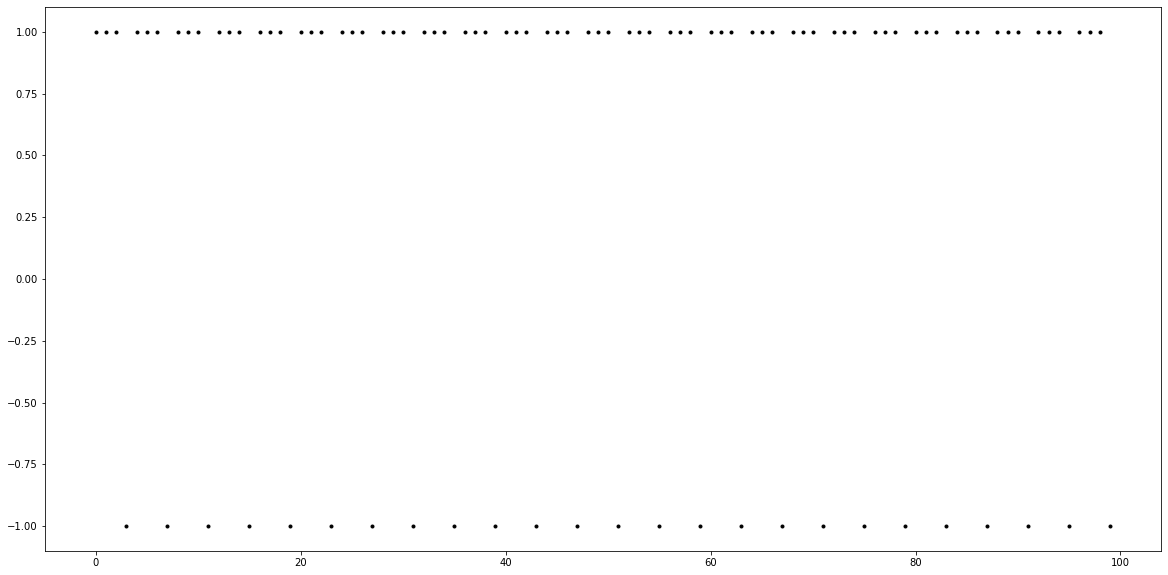

In [14]:
weights = np.ones(nvs)
weights[3::4] = -1

plt.figure(figsize=(20, 10))
plt.plot(weights.squeeze(), '.k')

weights = weights[np.newaxis, :, np.newaxis]
#print(weights.T)

In [15]:
t0 = time.time()

idirectVS_off = np.round(directVS_off/dt).astype(np.int)
w_sim = np.zeros((nr, nvs, nt))
for ir in range(nr):
    for ivs in range(nvs):
        w_sim[ir, ivs, :idirectVS_off[ir, ivs]]=1            
w_sim = np.concatenate((np.flip(w_sim, axis=-1), w_sim[:,:, 1:]), axis=-1)
w_sim = w_sim.reshape(nr, nvs//nsim, nsim, 2*nt - 1)
w_sim = np.sum(w_sim, axis=2)
w_sim[w_sim>0] = 1

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    w_sim  = filtfilt(smooth, 1, w_sim)    
    
G0sub_sim = np.sum(np.reshape(G0sub_ana*weights, (nr, nvs//nsim, nsim, nt)), axis=2)
print(G0sub_sim.shape)

# Add negative time to operators
Rtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), R), axis=-1)
Rtwosided_fft = np.fft.rfft(Rtwosided, 2*nt-1, axis=-1)/np.sqrt(2*nt-1)
Rtwosided_fft = Rtwosided_fft[...,:nfmax]
Rtwosided_fft = Rtwosided_fft.transpose(2, 0, 1) # R[f, r, s]

# Operators
Rop = MDC(Rtwosided_fft, nt=2*nt-1, nv=(nvs//nsim), dt=dt, dr=ds, twosided=True)
R1op = MDC(Rtwosided_fft, nt=2*nt-1, nv=(nvs//nsim), dt=dt, dr=ds, twosided=True, conj=True)
Rollop = Roll(dims=(2*nt-1, nr * (nvs//nsim)),
              axis=0, shift=-1)

# Input focusing function
fd_plus_sim = np.concatenate((np.flip(G0sub_sim, axis=-1).transpose(2, 0, 1),
                              np.zeros((nt - 1, nr, nvs//nsim))))

Wop = Diagonal(w_sim.transpose(2, 0, 1).flatten())
Iop = Identity(nr*(2*nt-1)*(nvs//nsim))

Mop = VStack([HStack([Iop, -1*Wop*Rop]),
              HStack([-1*Wop*Rollop*R1op, Iop])])*BlockDiag([Wop, Wop])
Gop = VStack([HStack([Iop, -1*Rop]),
              HStack([-1*Rollop*R1op, Iop])])

#dottest(Gop, 2*nr*(2*nt-1)*(nvs//nsim), 2*nr*(2*nt-1)*(nvs//nsim), verb=True)
#dottest(Mop, 2*nr*(2*nt-1)*(nvs//nsim), 2*nr*(2*nt-1)*(nvs//nsim), verb=True);

p0_minus_sim = Rop * fd_plus_sim.flatten()
p0_minus_sim = p0_minus_sim.reshape((2*nt-1), nr, (nvs//nsim)).transpose(1, 2, 0)

d_sim = Wop*Rop*fd_plus_sim.flatten()
d_sim = np.concatenate((d_sim.reshape(2*nt-1, nr, (nvs//nsim)), np.zeros((2*nt-1, nr, (nvs//nsim)))))

f1_inv_sim = lsqr(Mop, d_sim.flatten(), iter_lim=n_iter, show=True)[0]
f1_inv_sim = f1_inv_sim.reshape(2*(2*nt-1), nr, (nvs//nsim))

f1_inv_tot_sim = f1_inv_sim + np.concatenate((np.zeros((2*nt-1, nr, (nvs//nsim))), fd_plus_sim))

g_inv_sim = Gop*f1_inv_tot_sim.flatten()
g_inv_sim = g_inv_sim.reshape(2*(2*nt-1), nr, (nvs//nsim))

f1_inv_minus_sim, f1_inv_plus_sim =  f1_inv_tot_sim[:(2*nt-1)], f1_inv_tot_sim[(2*nt-1):]
g_inv_minus_sim, g_inv_plus_sim =  -g_inv_sim[:(2*nt-1)], np.flip(g_inv_sim[(2*nt-1):], axis=0)

g_inv_tot_sim = g_inv_minus_sim + g_inv_plus_sim

print('Sim source Marchenko took %f s' % (time.time()-t0))

(101, 50, 800)
 
LSQR            Least-squares solution of  Ax = b
The matrix A has 16149900 rows and 16149900 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       10
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.859e+02  3.859e+02    1.0e+00  2.7e-03
     1  0.00000e+00   1.666e+02  1.666e+02    4.3e-01  9.4e-01   1.1e+00  1.0e+00
     2  0.00000e+00   9.376e+01  9.376e+01    2.4e-01  3.9e-01   1.8e+00  2.2e+00
     3  0.00000e+00   6.983e+01  6.983e+01    1.8e-01  3.3e-01   2.1e+00  3.4e+00
     4  0.00000e+00   4.726e+01  4.726e+01    1.2e-01  3.3e-01   2.5e+00  5.1e+00
     5  0.00000e+00   3.630e+01  3.630e+01    9.4e-02  2.6e-01   2.9e+00  6.8e+00
     6  0.00000e+00   2.922e+01  2.922e+01    7.6e-02  2.2e-01   3.3e+00  8.5e+00
     7  0.00000e+00   2.086e+01  2.086e+01    5.4e-02  2.3e-01   3.6e+00  1.1e+01
     8  0.0

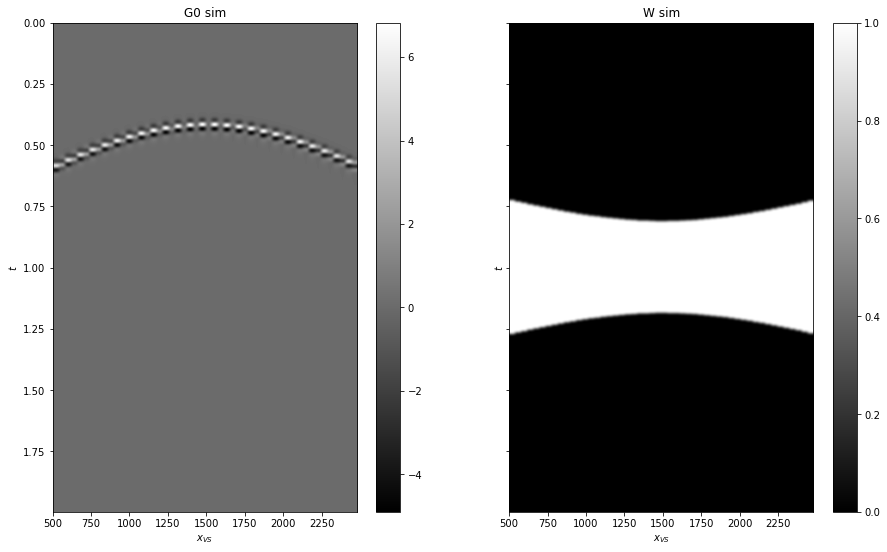

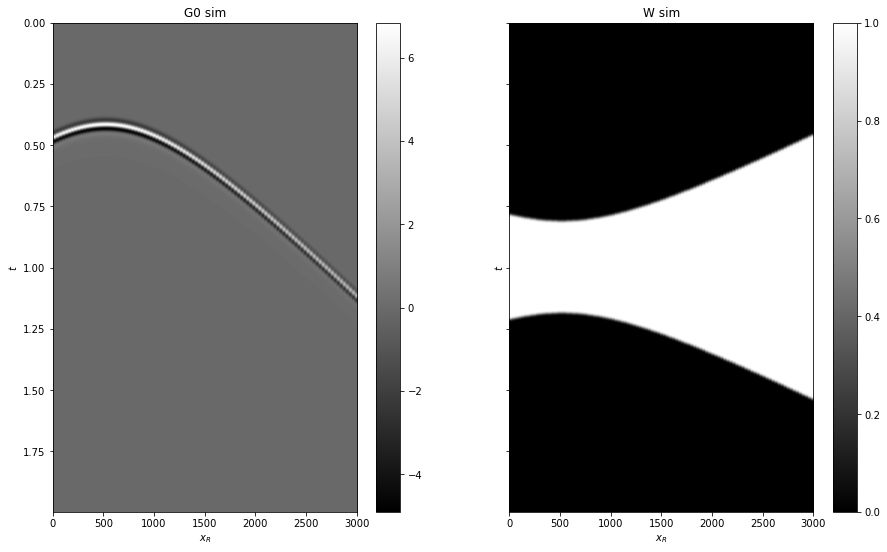

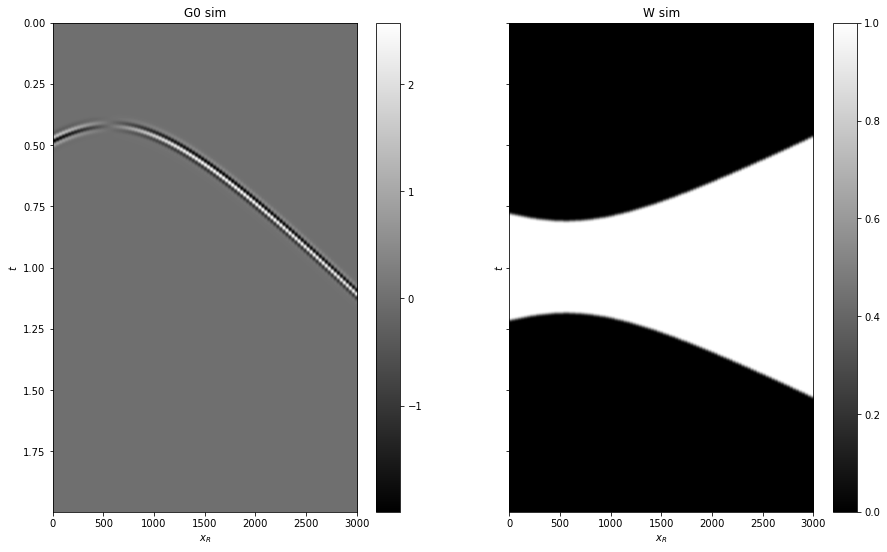

In [16]:
fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_sim[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[0].set_title('G0 sim'), axs[0].set_xlabel(r'$x_{VS}$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w_sim[nr//2].T, cmap='gray', extent=(vs[0][0], vs[0][-1], t[-1], t[0]))
axs[1].set_title('W sim'), axs[1].set_xlabel(r'$x_{VS}$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_sim[:, 0].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G0 sim'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w_sim[:, 0].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('W sim'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

fig, axs = plt.subplots(1, 2,  sharey=True, figsize=(15, 9))
im = axs[0].imshow(G0sub_sim[:, 1].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[0].set_title('G0 sim'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
fig.colorbar(im, ax=axs[0])
im = axs[1].imshow(w_sim[:, 1].T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title('W sim'), axs[1].set_xlabel(r'$x_R$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
fig.colorbar(im, ax=axs[1]);

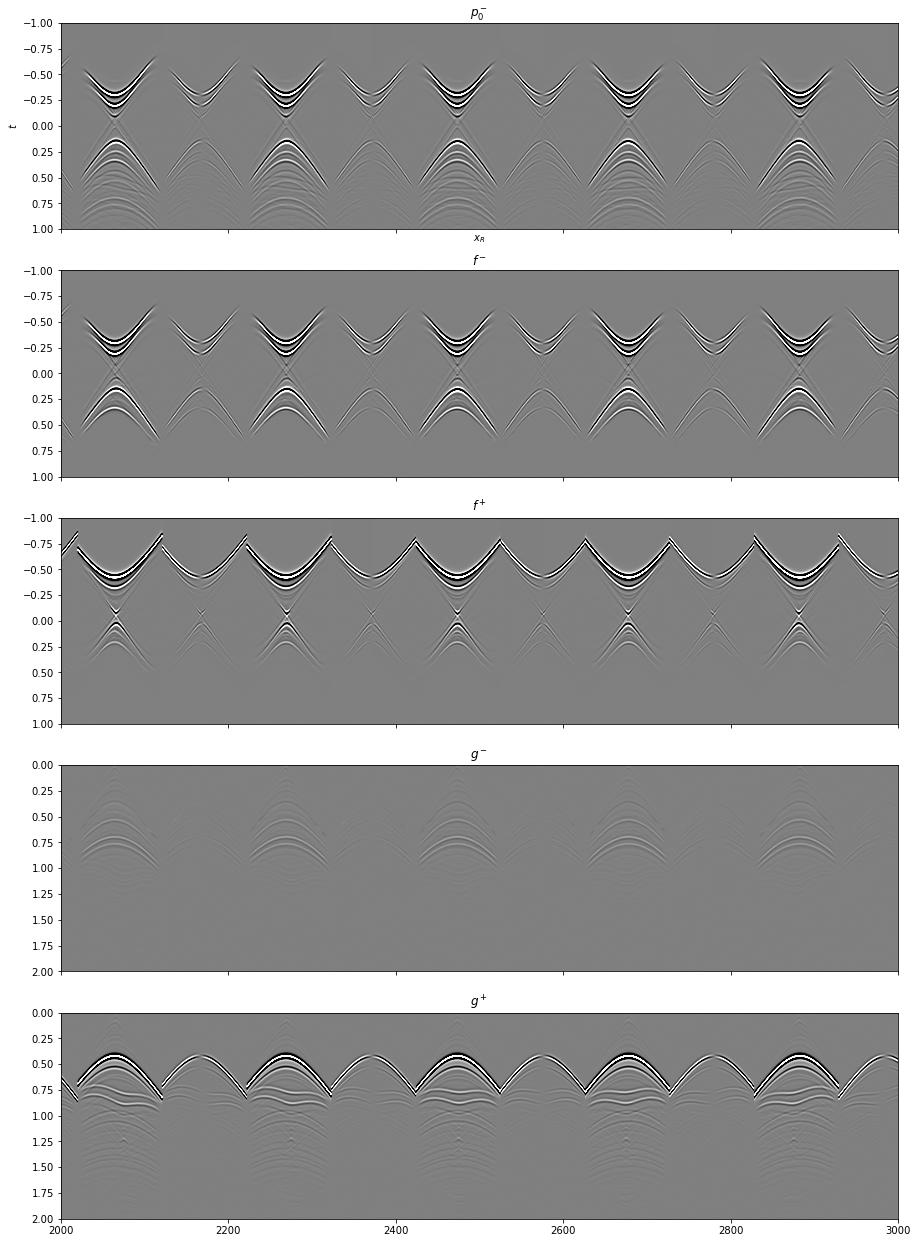

In [17]:
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(15, 22))
axs[0].imshow(p0_minus_sim.transpose(1, 0, 2).reshape(nr*(nvs//nsim), 2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*(nvs//nsim), t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);

axs[1].imshow(f1_inv_minus_sim.transpose(2, 1, 0).reshape(nr*(nvs//nsim),2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*(nvs//nsim), t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus_sim.transpose(2, 1, 0).reshape(nr*(nvs//nsim),2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*(nvs//nsim), t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);
axs[3].imshow(g_inv_minus_sim.transpose(2, 1, 0).reshape(nr*(nvs//nsim),2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*(nvs//nsim), t[-1], -t[-1]))
axs[3].set_title(r'$g^-$'), axs[0].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[3].set_ylim(2, 0);
axs[4].imshow(g_inv_plus_sim.transpose(2, 1, 0).reshape(nr*(nvs//nsim),2*nt-1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*(nvs//nsim), t[-1], -t[-1]))
axs[4].set_title(r'$g^+$'), axs[0].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(2, 0);
axs[4].set_xlim(2000, 3000);

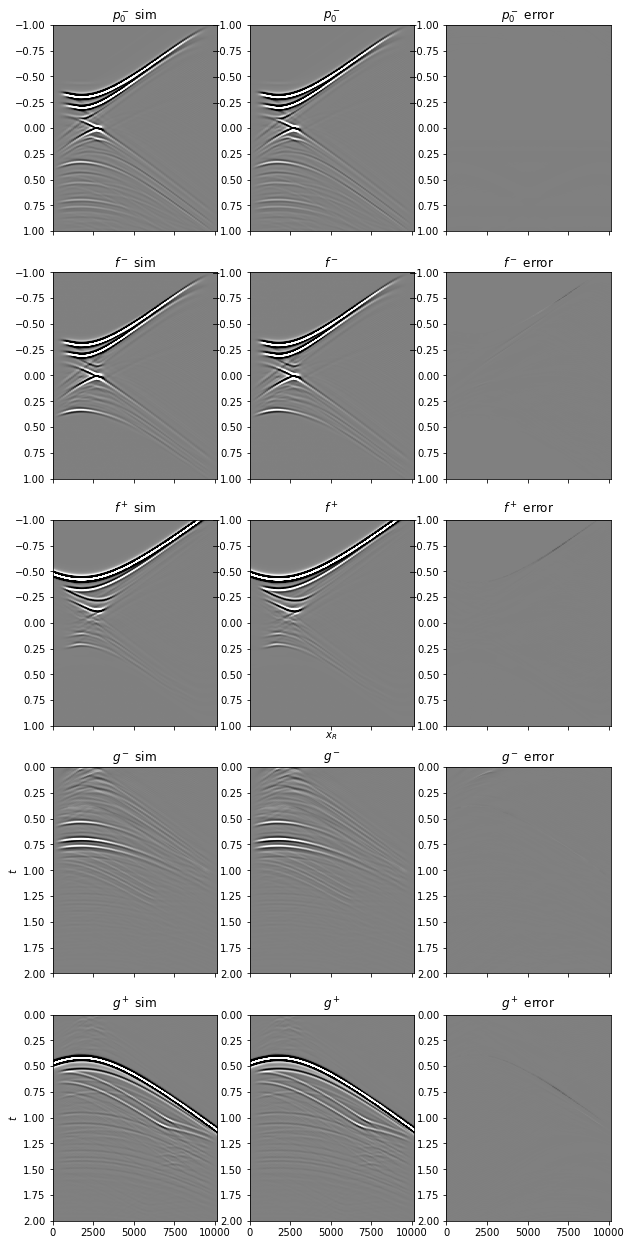

In [18]:
ivs=0

fig, axs = plt.subplots(5, 3, sharex=True, figsize=(10, 22))
axs[0][0].imshow(p0_minus_sim[:, ivs].T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0][0].set_title(r'$p_0^-$ sim')
axs[0][0].axis('tight')
axs[0][0].set_ylim(1, -1)
axs[0][1].imshow(np.sum(p0_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
                 vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0][1].set_title(r'$p_0^-$')
axs[0][1].axis('tight')
axs[0][1].set_ylim(1, -1)
axs[0][2].imshow(p0_minus_sim[:, ivs].T - np.sum(p0_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
                 vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[0][2].set_title(r'$p_0^-$ error')
axs[0][2].axis('tight')
axs[0][2].set_ylim(1, -1)
axs[1][0].imshow(f1_inv_minus_sim[:, :, ivs], cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1][0].set_title(r'$f^-$ sim')
axs[1][0].axis('tight')
axs[1][0].set_ylim(1, -1)
axs[1][1].imshow(np.sum(f1_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1][1].set_title(r'$f^-$')
axs[1][1].axis('tight')
axs[1][1].set_ylim(1, -1)
axs[1][2].imshow(f1_inv_minus_sim[:, :, ivs] - np.sum(f1_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[1][2].set_title(r'$f^-$ error')
axs[1][2].axis('tight')
axs[1][2].set_ylim(1, -1)

axs[2][0].imshow(f1_inv_plus_sim[:, :, ivs], cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2][0].set_title(r'$f^+$ sim')
axs[2][0].axis('tight')
axs[2][0].set_ylim(1, -1)
axs[2][1].imshow(np.sum(f1_inv_plus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2][1].set_title(r'$f^+$')
axs[2][1].set_xlabel(r'$x_R$')
axs[2][1].axis('tight')
axs[2][1].set_ylim(1, -1)
axs[2][2].imshow(f1_inv_plus_sim[:, :, ivs] - np.sum(f1_inv_plus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
                 vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[2][2].set_title(r'$f^+$ error')
axs[2][2].axis('tight')
axs[2][2].set_ylim(1, -1)

axs[3][0].imshow(g_inv_minus_sim[:, :, ivs], cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3][0].set_title(r'$g^-$ sim'), 
axs[3][0].set_ylabel(r'$t$')
axs[3][0].axis('tight')
axs[3][0].set_ylim(2, 0)
axs[3][1].imshow(np.sum(g_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3][1].set_title(r'$g^-$'), 
axs[3][1].axis('tight')
axs[3][1].set_ylim(2, 0)
axs[3][2].imshow(g_inv_minus_sim[:, :, ivs] - np.sum(g_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[3][2].set_title(r'$g^-$ error'), 
axs[3][2].axis('tight')
axs[3][2].set_ylim(2, 0)

axs[4][0].imshow(g_inv_plus_sim[:, :, ivs], cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4][0].set_title(r'$g^+$ sim'), 
axs[4][0].set_ylabel(r'$t$')
axs[4][0].axis('tight')
axs[4][0].set_ylim(2, 0)
axs[4][1].imshow(np.sum(g_inv_plus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4][1].set_title(r'$g^+$'), 
axs[4][1].axis('tight')
axs[4][1].set_ylim(2, 0)
axs[4][2].imshow(g_inv_plus_sim[:, :, ivs] - np.sum(g_inv_plus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nr*nvs, t[-1], -t[-1]))
axs[4][2].set_title(r'$g^+$ error'), 
axs[4][2].axis('tight')
axs[4][2].set_ylim(2, 0);

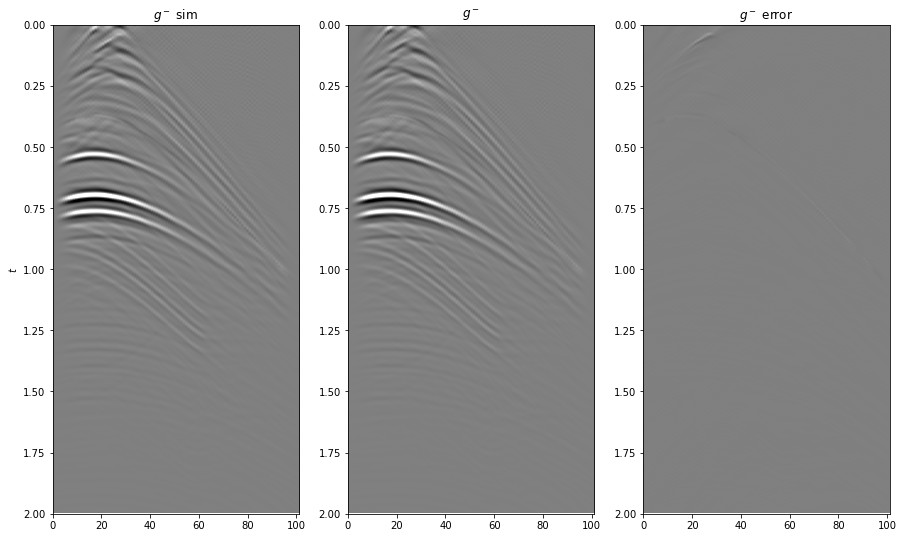

In [19]:
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(15, 9))

axs[0].imshow(g_inv_minus_sim[:, :, ivs], cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr, t[-1], -t[-1]))
axs[0].set_title(r'$g^-$ sim'), 
axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(np.sum(g_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr, t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), 
axs[1].axis('tight')
axs[1].set_ylim(2, 0)
axs[2].imshow(g_inv_minus_sim[:, :, ivs] - np.sum(g_inv_minus[:, ivs*nsim:(ivs+1)*nsim]*weights[:, ivs*nsim:(ivs+1)*nsim], axis=1).T, cmap='gray', 
              vmin=-1e-1, vmax=1e-1, extent=(0, nr, t[-1], -t[-1]))
axs[2].set_title(r'$g^-$ error'), 
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

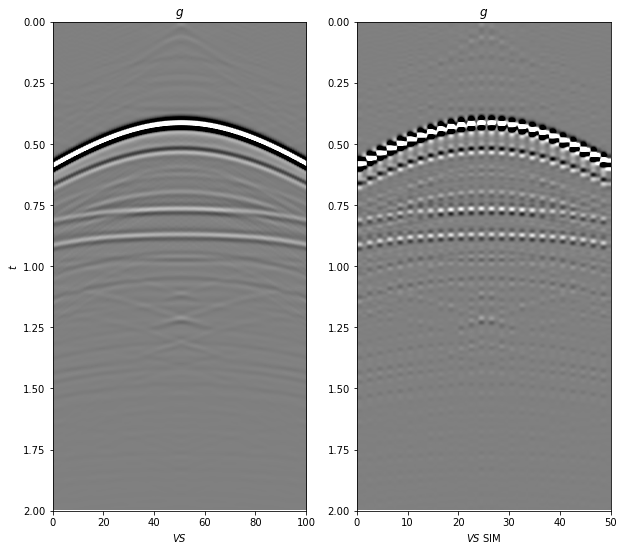

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 9))

axs[0].imshow(g_inv_tot[nr//2].T, cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nvs, t[-1], -t[-1]))
axs[0].set_title(r'$g$'), 
axs[0].set_ylabel(r'$t$')
axs[0].set_xlabel(r'$VS$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(g_inv_tot_sim[:, nr//2], cmap='gray', 
              vmin=-5e-1, vmax=5e-1, extent=(0, nvs//nsim, t[-1], -t[-1]))
axs[1].set_title(r'$g$'), 
axs[1].set_xlabel(r'$VS$ SIM'), 
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

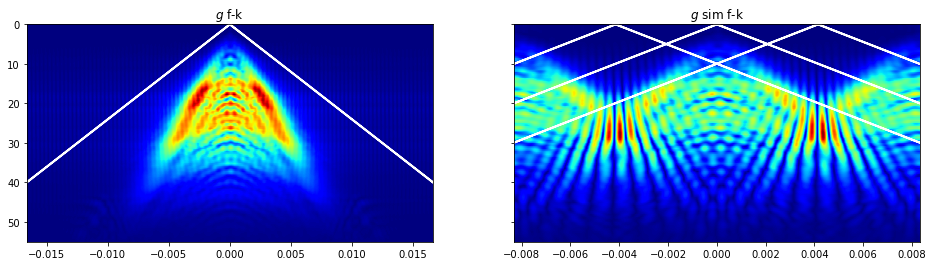

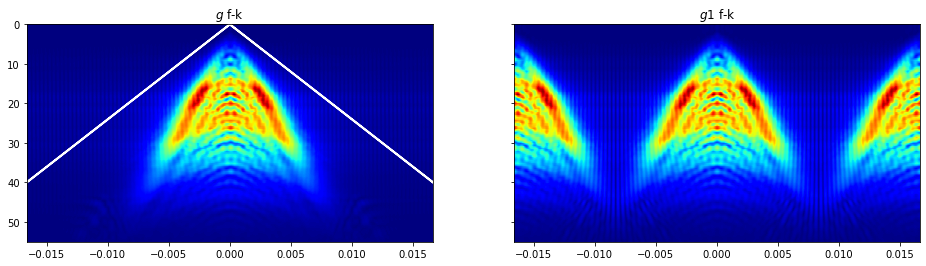

In [22]:
nfft = 2**10
FFTop = FFT2D(dims=[nt, nvs], nffts=[nfft, nfft], sampling=(dt, dr))
FFTop1 = FFT2D(dims=[nt, nvs//nsim], nffts=[nfft, nfft], sampling=(dt, 2*dr))
FFTop2 = FFT2D(dims=[nt, nvs], nffts=[nfft, nfft], sampling=(dt, dr))

kcritical = FFTop.f1 / vel
kcritical1 = FFTop1.f1 / vel

g_inv_tot1 = g_inv_tot.copy()
g_inv_tot1[:, ::2] = 0

Gfk = FFTop * ((g_inv_tot[nr//2, :, nt-1:].T).flatten())
Gfk = Gfk.reshape(nfft, nfft)
Gfk1 = FFTop2 * ((g_inv_tot1[nr//2, :, nt-1:].T).flatten())
Gfk1 = Gfk1.reshape(nfft, nfft)
Gfk_sim = FFTop1 * ((g_inv_tot_sim[nt-1:, nr//2]).flatten())
Gfk_sim = Gfk_sim.reshape(nfft, nfft)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
axs[0].imshow(np.fft.fftshift(np.abs(Gfk[:nfft//2]), axes=1), cmap='jet',
              extent = (-FFTop.f2[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0]))
axs[0].plot(kcritical, FFTop.f1, 'w', lw=2)
axs[0].plot(-kcritical, FFTop.f1, 'w', lw=2)
axs[0].set_title(r'$g$ f-k')
axs[0].axis('tight')
axs[0].set_xlim(-FFTop.f2[nfft//2-1], FFTop.f2[nfft//2-1])
axs[1].imshow(np.fft.fftshift(np.abs(Gfk_sim[:nfft//2]), axes=1), cmap='jet',
              extent = (-FFTop1.f2[nfft//2-1], FFTop1.f2[nfft//2-1], FFTop1.f1[nfft//2-1], FFTop1.f1[0]))
axs[1].plot(kcritical1, FFTop1.f1, 'w', lw=2)
axs[1].plot(-kcritical1, FFTop1.f1, 'w', lw=2)
axs[1].plot(kcritical1 - FFTop1.f2[nfft//4-1], FFTop1.f1, 'w', lw=2)
axs[1].plot(kcritical1 + FFTop1.f2[nfft//4-1], FFTop1.f1, 'w', lw=2)
axs[1].plot(-kcritical1 - FFTop1.f2[nfft//4-1], FFTop1.f1, 'w', lw=2)
axs[1].plot(-kcritical1 + FFTop1.f2[nfft//4-1], FFTop1.f1, 'w', lw=2)
axs[1].set_title(r'$g$ sim f-k')
axs[1].axis('tight')
axs[1].set_xlim(-FFTop1.f2[nfft//2-1], FFTop1.f2[nfft//2-1])
axs[1].set_ylim(55, 0);

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16, 4))
axs[0].imshow(np.fft.fftshift(np.abs(Gfk[:nfft//2]), axes=1), cmap='jet',
              extent = (-FFTop.f2[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f1[nfft//2-1], FFTop.f1[0]))
axs[0].plot(kcritical, FFTop.f1, 'w', lw=2)
axs[0].plot(-kcritical, FFTop.f1, 'w', lw=2)
axs[0].set_title(r'$g$ f-k')
axs[0].axis('tight')
axs[0].set_xlim(-FFTop.f2[nfft//2-1], FFTop.f2[nfft//2-1])
axs[1].imshow(np.fft.fftshift(np.abs(Gfk1[:nfft//2]), axes=1), cmap='jet',
              extent = (-FFTop2.f2[nfft//2-1], FFTop2.f2[nfft//2-1], FFTop2.f1[nfft//2-1], FFTop2.f1[0]))
axs[1].set_title(r'$g1$ f-k')
axs[1].axis('tight')
axs[1].set_xlim(-FFTop2.f2[nfft//2-1], FFTop2.f2[nfft//2-1])
axs[1].set_ylim(55, 0);